Краткое описание таблиц
collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, precision_recall_fscore_support
from sqlalchemy import create_engine

Делаю конфигурацию для подключения сервера:

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

Строка подключения:

In [3]:
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"

Создаю соединение с базой данных:

In [4]:
engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

Делаю подсчет числа виновников ДТП

In [5]:
query = '''
SELECT COUNT(DISTINCT id) AS count_parties
  FROM parties
 WHERE at_fault = 1;
'''
data_parties = pd.read_sql_query(query, con=engine)
display(data_parties.head())

,count_parties
0,1288127


In [6]:
count_parties = data_parties['count_parties'][0]
print("Количество виновников ДТП:", count_parties)

Количество виновников ДТП: 1288127


Делаю определение размера базы данных

In [7]:
query = '''
SELECT pg_size_pretty(pg_database_size(current_database()));
'''
data_db_size = pd.read_sql_query(query, con=engine)
print("Размер базы данных:", data_db_size['pg_size_pretty'][0])

Размер базы данных: 790 MB


Информация о названии таблиц в базе данных

In [8]:
query = '''
SELECT table_name
  FROM information_schema.tables
 WHERE table_schema NOT IN ('information_schema','pg_catalog');
'''
data_tables = pd.read_sql_query(query, con=engine)
print("Названия таблиц в базе данных:", data_tables['table_name'].tolist())

Названия таблиц в базе данных: ['case_ids', 'collisions', 'parties', 'vehicles']


Название колонок и их типы данных для каждой таблицы

In [9]:
query = '''
SELECT table_name, 
       column_name, 
       data_type 
  FROM information_schema.columns
 WHERE table_name IN ('case_ids', 'collisions', 'parties', 'vehicles');
'''
data_columns = pd.read_sql_query(query, con=engine)
display ("Колонки и их типы данных:", data_columns)

'Колонки и их типы данных:'

,table_name,column_name,data_type
0,parties,party_number,integer
1,collisions,intersection,integer
2,parties,at_fault,integer
3,parties,insurance_premium,integer
4,collisions,distance,real
5,collisions,collision_date,date
6,parties,cellphone_in_use,integer
7,vehicles,id,integer
8,collisions,collision_time,time without time zone
9,vehicles,party_number,integer


Проверяю первичные и внешние ключчи

In [10]:
query = '''
SELECT constraint_name,
       table_name,
       column_name
  FROM information_schema.key_column_usage
'''
data_keys = pd.read_sql_query(query, con=engine)
display ("Первичные и внешние ключи:", data_keys)

'Первичные и внешние ключи:'

,constraint_name,table_name,column_name
0,pg_proc_oid_index,pg_proc,oid
1,pg_proc_proname_args_nsp_index,pg_proc,proname
2,pg_proc_proname_args_nsp_index,pg_proc,proargtypes
3,pg_proc_proname_args_nsp_index,pg_proc,pronamespace
4,pg_type_oid_index,pg_type,oid
...,...,...,...
162,parties_pk,parties,id
163,vehicles_pk,vehicles,id
164,collisions_case_ids_case_id_fk,collisions,case_id
165,parties_case_ids_case_id_fk,parties,case_id


Проверяю уникальность значений в столбце case_id в таблице collisions

In [11]:
query = '''
SELECT COUNT(case_id) AS total_ids,
       COUNT(DISTINCT case_id) AS unique_ids
  FROM collisions;
'''
data_collisions_unique = pd.read_sql_query(query, con=engine)
display ("Уникальность case_id в таблице collisions:", data_collisions_unique)

'Уникальность case_id в таблице collisions:'

,total_ids,unique_ids
0,1400000,1400000


Проверка соответствия первичных и внешних ключей между таблицами

In [12]:
total_ids = data_collisions_unique['total_ids'][0]
unique_ids = data_collisions_unique['unique_ids'][0]
print("Количество всех case_id:", total_ids)
print("Количество уникальных case_id:", unique_ids)
print("Уникальны ли значения:", total_ids == unique_ids)

Количество всех case_id: 1400000
Количество уникальных case_id: 1400000
Уникальны ли значения: True


1. Успешное установление соединения с базой данных.
2. Все таблицы  (case_ids, collisions, parties, vehicles) есть в базе данных.
3. Проверены первичные и внешние ключи.
4. Таблицы связаны между собой через поле case_id.
5. Уникальность значений case_id в таблице collisions подтверждена.

##  Проведите статистический анализ факторов ДТП

Создаю запрос для получения количества аварий по месяцам.

In [13]:
query = '''
SELECT DATE_TRUNC('month', collision_date) AS month, COUNT(*) AS accident_count
FROM collisions
GROUP BY month
ORDER BY month;
'''
data_monthly_accidents = pd.read_sql_query(query, con=engine)

Строю график

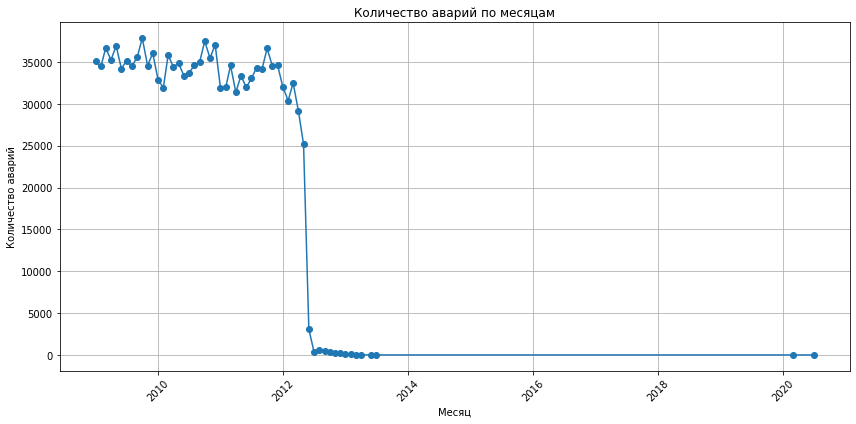

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(data_monthly_accidents['month'], data_monthly_accidents['accident_count'], marker='o')
plt.title('Количество аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. В период с 2010 по 2011 год происходит большое количество аварий - примерно 35 тыс в месяц.
2. С 2012 по 2013 год количество аварий резко снизилось до менее 5 тыс. в месяц. 
3. С 2013 года количество аварий на низком уровне.

## Создайте модель для оценки водительского риска

Задачи:

1. Нужно проанализировать серьёзность повреждений транспортного средства при анализе  состояния дороги в момент ДТП.

Таблица: vehicles, collisions 

2. Нужно проанализировать зависимость типа транспортного средства от серьёзности ДТП.

Таблица: vehicles, collisions

3. Нужно проанализировать кол-во ДТП в зависимости от времени суток

Таблица: collisions

4. Нужно проанализировать влияние погоды на кол-во ДТТП

Таблица: collisions

5. Нужно проанализировать самые частые причины ДТП

Таблица: collisions

6. Нужно проанализировать, влияют ли мобильные телефоны на кол-во ДТП

Таблица: parties

Выполнение первой задачи

In [15]:
query = '''
SELECT c.road_condition_1, c.collision_damage, COUNT(*) AS damage_count
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
GROUP BY c.road_condition_1, c.collision_damage
ORDER BY damage_count DESC;
'''
data = pd.read_sql_query(query, con=engine)

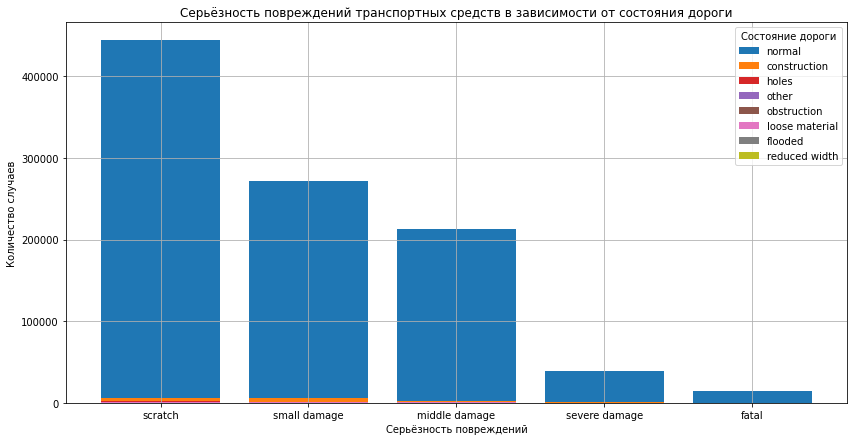

In [16]:
plt.figure(figsize=(14, 7))
for condition in data['road_condition_1'].unique():
    subset = data[data['road_condition_1'] == condition]
    plt.bar(subset['collision_damage'], subset['damage_count'], label=condition)

plt.title('Серьёзность повреждений транспортных средств в зависимости от состояния дороги')
plt.xlabel('Серьёзность повреждений')
plt.ylabel('Количество случаев')
plt.legend(title='Состояние дороги')
plt.grid(True)
plt.show()

Большинство ДТП происходит на дорогах с нормальным состоянием. На дорах с поврежденими меньше аварий.
Вероятно, водители более осторожны на дорогах с ямами и прочими проблемами.

Выполнение второй задачи

In [17]:
query = '''
SELECT v.vehicle_type, c.collision_damage, COUNT(*) AS damage_count
FROM vehicles AS v
JOIN collisions AS c ON v.case_id = c.case_id
GROUP BY v.vehicle_type, c.collision_damage
ORDER BY damage_count DESC;
'''
data = pd.read_sql_query(query, con=engine)

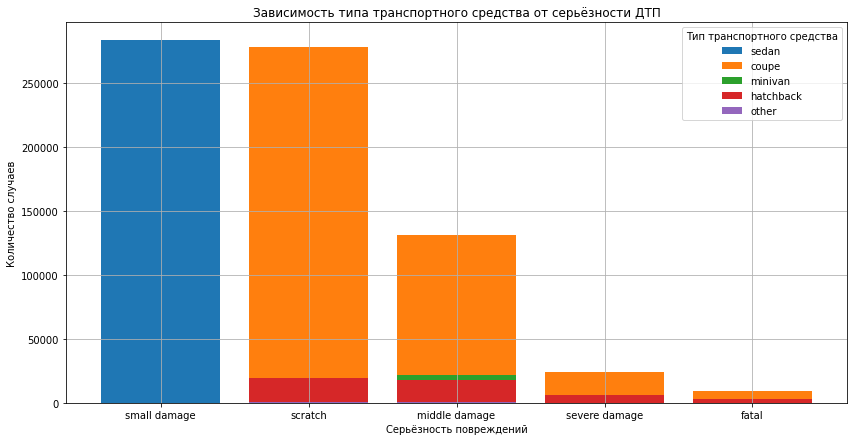

In [18]:
plt.figure(figsize=(14, 7))
for v_type in data['vehicle_type'].unique():
    subset = data[data['vehicle_type'] == v_type]
    plt.bar(subset['collision_damage'], subset['damage_count'], label=v_type)

plt.title('Зависимость типа транспортного средства от серьёзности ДТП')
plt.xlabel('Серьёзность повреждений')
plt.ylabel('Количество случаев')
plt.legend(title='Тип транспортного средства')
plt.grid(True)
plt.show()

Небольших повреждений больше всего у седана. Царапин больше всего у купе. Средний повреждений меньше, чем царапн и небольших повреждений, встречаются чаще всего у купе и минивэнов. Серьезные повреждения и фатальные случаи встречаются меньше, чаще всего происходят у купе.

## Проведите анализ важности факторов ДТП

In [19]:
query = '''
SELECT *
  FROM parties AS p
       FULL JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
       FULL JOIN collisions AS c ON p.case_id = c.case_id
 WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''
data = pd.read_sql_query(query, con=engine)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           196837 non-null  int64  
 1   case_id                      196837 non-null  object 
 2   party_number                 196837 non-null  int64  
 3   party_type                   196837 non-null  object 
 4   at_fault                     196837 non-null  int64  
 5   insurance_premium            176607 non-null  float64
 6   party_sobriety               193212 non-null  object 
 7   party_drug_physical          25148 non-null   object 
 8   cellphone_in_use             171464 non-null  float64
 9   id                           56248 non-null   float64
 10  case_id                      56248 non-null   object 
 11  party_number                 56248 non-null   float64
 12  vehicle_type                 56248 non-null   object 
 13 

In [21]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,196837.0,2.589799e+06,97569.718519,1687780.0,2511773.00,2593207.0,2673872.00,2752408.0
party_number,196837.0,1.507745e+00,0.665083,1.0,1.00,1.0,2.00,10.0
at_fault,196837.0,5.235144e-01,0.499448,0.0,0.00,1.0,1.00,1.0
insurance_premium,176607.0,3.894500e+01,16.230328,0.0,25.00,36.0,50.00,105.0
cellphone_in_use,171464.0,2.363178e-02,0.151899,0.0,0.00,0.0,0.00,1.0
id,56248.0,1.429235e+06,54399.757417,985527.0,1386472.75,1432047.0,1476086.25,1517653.0
party_number,56248.0,1.527432e+00,0.662507,1.0,1.00,1.0,2.00,9.0
vehicle_age,54554.0,4.856472e+00,3.234503,0.0,3.00,4.0,7.00,161.0
distance,196837.0,6.624782e+02,7915.264303,0.0,10.00,100.0,500.00,1584000.0
intersection,195850.0,2.018994e-01,0.401419,0.0,0.00,0.0,0.00,1.0


Удаляю стобцы, не влияющие на вероятность стать виновником ДТП:

- уникальный номер (id), 
- номер случая (case_id), 
- номер участника (party_number), 
- тип участника (party_type), 
- дата ДТП (collision_date), 
- время ДТП (collision_time).

Оставленные столбцы:

- страховая премия (insurance_premium), 
- трезвость участника (party_sobriety), 
- состояние участника (party_drug_physical), 
- использование телефона (cellphone_in_use), 
- тип кузова (vehicle_type), 
- тип трансмиссии (vehicle_transmission), 
- сколько лет авто (vehicle_age), 
- регион (county_location), 
- расстояние (distance), 
- направление (direction), 
- перекрёсток или нет (intersection), 
- погода (weather_1), 
- тип дороги (location_type), 
- урон (collision_damage), 
- количество участников (party_count), 
- главный фактор ДТП (primary_collision_factor), 
- категория нарушения (pcf_violation_category), 
- тип столкновения (type_of_collision), 
- тип участников (motor_vehicle_involved_with), 
- тип покрытия (road_surface), состояние дороги (road_condition_1), 
- освещённость (lighting), 
- устройство слежения (control_device).

In [22]:
data.drop(columns=[
    'case_id', 'id', 'party_number', 'county_city_location', 'collision_date', 'collision_time', 'party_type'
], inplace=True, errors='ignore')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     196837 non-null  int64  
 1   insurance_premium            176607 non-null  float64
 2   party_sobriety               193212 non-null  object 
 3   party_drug_physical          25148 non-null   object 
 4   cellphone_in_use             171464 non-null  float64
 5   vehicle_type                 56248 non-null   object 
 6   vehicle_transmission         55389 non-null   object 
 7   vehicle_age                  54554 non-null   float64
 8   county_location              196837 non-null  object 
 9   distance                     196837 non-null  float64
 10  direction                    153975 non-null  object 
 11  intersection                 195850 non-null  float64
 12  weather_1                    196183 non-null  object 
 13 

In [24]:
display (data.head(15))

,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,county_location,distance,...,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device
0,0,NaN,impairment unknown,G,0.0,None,None,NaN,los angeles,128.0,...,small damage,4,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
1,0,26.0,had not been drinking,None,0.0,None,None,NaN,los angeles,900.0,...,small damage,7,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
2,0,42.0,had not been drinking,None,0.0,None,None,NaN,los angeles,90.0,...,small damage,6,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none
3,0,23.0,had not been drinking,None,0.0,None,None,NaN,santa clara,500.0,...,small damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
4,0,44.0,had not been drinking,None,NaN,None,None,NaN,los angeles,707.0,...,small damage,6,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,functioning
5,0,NaN,impairment unknown,G,0.0,None,None,NaN,los angeles,389.0,...,middle damage,5,vehicle code violation,following too closely,rear end,other motor vehicle,dry,normal,daylight,none
6,0,NaN,had not been drinking,None,0.0,None,None,NaN,riverside,1056.0,...,small damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
7,1,18.0,had not been drinking,None,0.0,None,None,NaN,orange,263.0,...,severe damage,5,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
8,0,53.0,had not been drinking,None,0.0,sedan,manual,4.0,santa cruz,1200.0,...,small damage,5,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,none
9,0,37.0,had not been drinking,None,0.0,sedan,auto,4.0,orange,0.0,...,fatal,5,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning


Переименую отличающиеся столбцы:

In [25]:
data.rename(columns={'weather_1':'weather', 'road_condition_1':'road_condition'}, inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     196837 non-null  int64  
 1   insurance_premium            176607 non-null  float64
 2   party_sobriety               193212 non-null  object 
 3   party_drug_physical          25148 non-null   object 
 4   cellphone_in_use             171464 non-null  float64
 5   vehicle_type                 56248 non-null   object 
 6   vehicle_transmission         55389 non-null   object 
 7   vehicle_age                  54554 non-null   float64
 8   county_location              196837 non-null  object 
 9   distance                     196837 non-null  float64
 10  direction                    153975 non-null  object 
 11  intersection                 195850 non-null  float64
 12  weather                      196183 non-null  object 
 13 

In [27]:
data_info = data.describe(include='all')
display (data_info)

,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,county_location,distance,...,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition,lighting,control_device
count,196837.000000,176607.000000,193212,25148,171464.000000,56248,55389,54554.000000,196837,1.968370e+05,...,196837,196837.000000,196098,193173,195280,196000,195564,195694,196116,195864
unique,NaN,NaN,6,5,NaN,3,2,NaN,58,NaN,...,4,NaN,5,22,7,9,4,8,5,4
top,NaN,NaN,had not been drinking,G,NaN,sedan,manual,NaN,los angeles,NaN,...,small damage,NaN,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none
freq,NaN,NaN,157684,20525,NaN,37180,29318,NaN,64488,NaN,...,160097,NaN,186926,69309,76645,147291,175564,189563,136370,132665
mean,0.523514,38.945002,NaN,NaN,0.023632,NaN,NaN,4.856472,NaN,6.624782e+02,...,NaN,2.106093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.499448,16.230328,NaN,NaN,0.151899,NaN,NaN,3.234503,NaN,7.915264e+03,...,NaN,0.726720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000e+00,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,25.000000,NaN,NaN,0.000000,NaN,NaN,3.000000,NaN,1.000000e+01,...,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,36.000000,NaN,NaN,0.000000,NaN,NaN,4.000000,NaN,1.000000e+02,...,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,50.000000,NaN,NaN,0.000000,NaN,NaN,7.000000,NaN,5.000000e+02,...,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
missing_values = data.isnull().sum()
print(missing_values)

at_fault                            0
insurance_premium               20230
party_sobriety                   3625
party_drug_physical            171689
cellphone_in_use                25373
vehicle_type                   140589
vehicle_transmission           141448
vehicle_age                    142283
county_location                     0
distance                            0
direction                       42862
intersection                      987
weather                           654
location_type                  109480
collision_damage                    0
party_count                         0
primary_collision_factor          739
pcf_violation_category           3664
type_of_collision                1557
motor_vehicle_involved_with       837
road_surface                     1273
road_condition                   1143
lighting                          721
control_device                    973
dtype: int64


In [29]:
data['insurance_premium'].unique()

array([ nan,  26.,  42.,  23.,  44.,  18.,  53.,  37.,  28.,  56.,  57.,
        39.,  21.,  25.,  27.,  68.,  59.,  36.,  29.,  66.,  40.,  35.,
        34.,  31.,  76.,  38.,  22.,  19.,  81.,  54.,  60.,  50.,  77.,
        46.,  43.,  33.,  47.,  51.,  49.,  41.,  63.,  71.,  74.,  55.,
        70.,  78.,  20.,  61.,  73.,  48.,  32.,  64.,  30.,  45.,  24.,
        16.,  79.,  17.,  58.,  67.,  52.,  85.,  62.,  65.,  82.,  72.,
        89.,  69.,  75.,  84.,  92.,  80., 100.,  87.,  83.,  86.,  15.,
        14.,  12.,  13.,  88.,  90.,  95.,  91.,  93.,   0.,  94.,   7.,
         8.,  11.,  10.,  99.,   5.,   6.,  96.,   9., 105.,   4.,   3.,
       101.,   1.,  97.,  98., 102., 104.,   2.])

insurance_premium - сумма страховой выплаты, заполню медианным значением.

In [30]:
data['insurance_premium'].unique()

array([ nan,  26.,  42.,  23.,  44.,  18.,  53.,  37.,  28.,  56.,  57.,
        39.,  21.,  25.,  27.,  68.,  59.,  36.,  29.,  66.,  40.,  35.,
        34.,  31.,  76.,  38.,  22.,  19.,  81.,  54.,  60.,  50.,  77.,
        46.,  43.,  33.,  47.,  51.,  49.,  41.,  63.,  71.,  74.,  55.,
        70.,  78.,  20.,  61.,  73.,  48.,  32.,  64.,  30.,  45.,  24.,
        16.,  79.,  17.,  58.,  67.,  52.,  85.,  62.,  65.,  82.,  72.,
        89.,  69.,  75.,  84.,  92.,  80., 100.,  87.,  83.,  86.,  15.,
        14.,  12.,  13.,  88.,  90.,  95.,  91.,  93.,   0.,  94.,   7.,
         8.,  11.,  10.,  99.,   5.,   6.,  96.,   9., 105.,   4.,   3.,
       101.,   1.,  97.,  98., 102., 104.,   2.])

In [31]:
data['party_sobriety'].unique()

array(['impairment unknown', 'had not been drinking', None,
       'not applicable', 'had been drinking, under influence',
       'had been drinking, not under influence',
       'had been drinking, impairment unknown'], dtype=object)

In [32]:
data['party_sobriety'].fillna('impairment unknown', inplace=True)

In [33]:
data['party_sobriety'].replace({
    'had been drinking, under influence': 'had been drinking',
    'had been drinking, not under influence': 'had been drinking',
    'had been drinking, impairment unknown': 'had been drinking',
    'impairment unknown': 'impairment unknown',
    'had not been drinking': 'had not been drinking',
    'not applicable': 'not applicable'
}, inplace=True)

In [34]:
print(data['party_sobriety'].unique())

['impairment unknown' 'had not been drinking' 'not applicable'
 'had been drinking']


party_sobriety - состояние трезвости, пропуски заполним "неизвестно", также уберем повторы.

In [35]:
print(data['party_drug_physical'].unique())

['G' None 'not applicable' 'sleepy/fatigued' 'under drug influence'
 'impairment - physical']


In [36]:
data['party_drug_physical'].replace('G', 'impairment unknown', inplace=True)
data['party_drug_physical'].fillna('impairment unknown', inplace=True)

In [37]:
print(data['party_drug_physical'].unique())

['impairment unknown' 'not applicable' 'sleepy/fatigued'
 'under drug influence' 'impairment - physical']


party_drug_physical: заменим G на "неизвестно" и заполним "неизвестно" пропуски.

In [38]:
print(data['cellphone_in_use'].unique())

[ 0. nan  1.]


In [39]:
data['cellphone_in_use'] = data['cellphone_in_use'].astype(object)
data['cellphone_in_use'].fillna('unknown', inplace=True)

In [40]:
print(data['cellphone_in_use'].unique())

[0.0 'unknown' 1.0]


cellphone_in_use дабавим значение "неизвестно"

In [41]:
print(data['vehicle_type'].unique())

[None 'sedan' 'coupe' 'other']


In [42]:
data['vehicle_type'].fillna('other', inplace=True)

In [43]:
print(data['vehicle_type'].unique())

['other' 'sedan' 'coupe']


неизвестное поменяем на "другое"

In [44]:
print(data['vehicle_transmission'].unique())

[None 'manual' 'auto']


In [45]:
data['vehicle_transmission'].fillna('other', inplace=True)

In [46]:
print(data['vehicle_transmission'].unique())

['other' 'manual' 'auto']


неизвестное поменяем на "другое"

In [47]:
print(data['vehicle_age'].unique())

[ nan   4.   3.   9.   6.  10.   0.  12.   2.   5.   1.  11.   7.   8.
  13.  14.  16.  15.  17. 161.  19.]


In [48]:
value_counts_vehicle = data['vehicle_age'].value_counts()
print(value_counts_vehicle)

3.0      11012
4.0       7157
2.0       6048
5.0       5565
6.0       3940
7.0       3838
8.0       3509
0.0       3087
9.0       2770
1.0       2545
10.0      1942
11.0      1380
12.0       879
13.0       551
14.0       282
15.0        37
16.0         6
17.0         3
161.0        2
19.0         1
Name: vehicle_age, dtype: int64


In [49]:
data = data[~data['vehicle_age'].isin(value_counts_vehicle[value_counts_vehicle < 30].index)]

In [50]:
data['vehicle_age'].fillna(data['vehicle_age'].mode()[0], inplace=True)

In [51]:
print(data['vehicle_age'].unique())

[ 3.  4.  9.  6. 10.  0. 12.  2.  5.  1. 11.  7.  8. 13. 14. 15.]


В vehicle_age удалим значения, корых мало, неизвестное заменим модой

In [52]:
print(data['direction'].unique())

['north' 'south' 'east' None 'west']


In [53]:
data['direction'].fillna('unknown', inplace=True)

In [54]:
print(data['direction'].unique())

['north' 'south' 'east' 'unknown' 'west']


в "направлении" добавим "неизвестно"

In [55]:
print(data['intersection'].unique())

[ 0.  1. nan]


In [56]:
data['intersection'].fillna('unknown', inplace=True)

In [57]:
print(data['intersection'].unique())

[0.0 1.0 'unknown']


также в intersection

In [58]:
print(data['primary_collision_factor'].unique())

['vehicle code violation' 'unknown' None 'other than driver'
 'other improper driving' 'fell asleep']


In [59]:
data['primary_collision_factor'].fillna('unknown', inplace=True)

In [60]:
print(data['primary_collision_factor'].unique())

['vehicle code violation' 'unknown' 'other than driver'
 'other improper driving' 'fell asleep']


пропуски заменим на "неизвестно"

In [61]:
print(data['pcf_violation_category'].unique())

['speeding' 'following too closely' 'traffic signals and signs' 'dui'
 'unsafe lane change' 'automobile right of way'
 'other hazardous violation' 'improper turning' 'unknown'
 'unsafe starting or backing' 'wrong side of road' 'pedestrian violation'
 None 'other than driver (or pedestrian)' 'pedestrian right of way'
 'improper passing' 'other improper driving' 'other equipment'
 'impeding traffic' 'hazardous parking' 'lights' 'brakes' 'fell asleep']


In [62]:
value_counts_pcf_violation = data['pcf_violation_category'].value_counts()
print(value_counts_pcf_violation)

speeding                             69305
improper turning                     28722
automobile right of way              20992
unsafe lane change                   18397
dui                                  14224
traffic signals and signs             9162
unsafe starting or backing            7666
unknown                               5189
following too closely                 4562
wrong side of road                    3936
other than driver (or pedestrian)     3377
other hazardous violation             1921
improper passing                      1895
pedestrian violation                  1384
other improper driving                 908
pedestrian right of way                888
other equipment                        248
hazardous parking                      173
impeding traffic                       162
brakes                                  25
lights                                  19
fell asleep                              6
Name: pcf_violation_category, dtype: int64


In [63]:
data['pcf_violation_category'] = data['pcf_violation_category'].replace(value_counts_pcf_violation[value_counts_pcf_violation < 30].index, 'unknown')

In [64]:
data['pcf_violation_category'].fillna('unknown', inplace=True)

In [65]:
print(data['pcf_violation_category'].unique())

['speeding' 'following too closely' 'traffic signals and signs' 'dui'
 'unsafe lane change' 'automobile right of way'
 'other hazardous violation' 'improper turning' 'unknown'
 'unsafe starting or backing' 'wrong side of road' 'pedestrian violation'
 'other than driver (or pedestrian)' 'pedestrian right of way'
 'improper passing' 'other improper driving' 'other equipment'
 'impeding traffic' 'hazardous parking']


в pcf_violation_category уберем значения, которых мало, а также  заполним пропуски

In [66]:
print(data['type_of_collision'].unique())

['rear end' 'broadside' 'sideswipe' 'head-on' 'hit object' 'other' None
 'overturned']


In [67]:
data['type_of_collision'].fillna('other', inplace=True)

In [68]:
print(data['type_of_collision'].unique())

['rear end' 'broadside' 'sideswipe' 'head-on' 'hit object' 'other'
 'overturned']


пропуски заполним "другое"

In [69]:
print(data['motor_vehicle_involved_with'].unique())

['other motor vehicle' 'bicycle' 'fixed object' 'non-collision'
 'other object' 'motor vehicle on other roadway' None
 'parked motor vehicle' 'animal' 'train']


In [70]:
value_counts_motor_vehicle = data['motor_vehicle_involved_with'].value_counts()
print(value_counts_motor_vehicle)

other motor vehicle               147281
fixed object                       22892
parked motor vehicle               10289
other object                        6704
non-collision                       3985
bicycle                             2737
motor vehicle on other roadway      1422
animal                               656
train                                 23
Name: motor_vehicle_involved_with, dtype: int64


In [71]:
data['motor_vehicle_involved_with'] = data['motor_vehicle_involved_with'].replace('train', 'other')

In [72]:
data['motor_vehicle_involved_with'].fillna('other', inplace=True)

In [73]:
print(data['motor_vehicle_involved_with'].unique())

['other motor vehicle' 'bicycle' 'fixed object' 'non-collision'
 'other object' 'motor vehicle on other roadway' 'other'
 'parked motor vehicle' 'animal']


пропуски и train заменим на "другое"

In [74]:
print(data['road_surface'].unique())

['dry' 'wet' None 'snowy' 'slippery']


In [75]:
value_counts_road_surface = data['road_surface'].value_counts()
print(value_counts_road_surface)

dry         175554
wet          18918
snowy          926
slippery       154
Name: road_surface, dtype: int64


In [76]:
data['road_surface'].fillna('other', inplace=True)

In [77]:
print(data['road_surface'].unique())

['dry' 'wet' 'other' 'snowy' 'slippery']


пропуски заменим на "другое"

In [78]:
print(data['road_condition'].unique())

['normal' 'holes' 'construction' 'loose material' 'other' None
 'obstruction' 'reduced width' 'flooded']


In [79]:
value_counts_road_condition = data['road_condition'].value_counts()
print(value_counts_road_surface)

dry         175554
wet          18918
snowy          926
slippery       154
Name: road_surface, dtype: int64


In [80]:
data['road_condition'].fillna('other', inplace=True)

In [81]:
print(data['road_condition'].unique())

['normal' 'holes' 'construction' 'loose material' 'other' 'obstruction'
 'reduced width' 'flooded']


пропуски заменим на "другое"

In [82]:
print(data['lighting'].unique())

['daylight' 'dark with no street lights' 'dusk or dawn'
 'dark with street lights' None 'dark with street lights not functioning']


In [83]:
value_counts_lighting = data['lighting'].value_counts()
print(value_counts_lighting)

daylight                                   136360
dark with street lights                     38094
dark with no street lights                  14430
dusk or dawn                                 6774
dark with street lights not functioning       446
Name: lighting, dtype: int64


In [84]:
data['lighting'].fillna('other', inplace=True)

In [85]:
print(data['lighting'].unique())

['daylight' 'dark with no street lights' 'dusk or dawn'
 'dark with street lights' 'other'
 'dark with street lights not functioning']


пропуски заменим на "другое"

In [86]:
print(data['control_device'].unique())

['none' 'functioning' None 'obscured' 'not functioning']


In [87]:
data['control_device'].fillna('none', inplace=True)

In [88]:
print(data['control_device'].unique())

['none' 'functioning' 'obscured' 'not functioning']


пропуски заменим на none

In [89]:
print(data['weather'].unique())

['clear' 'cloudy' 'fog' 'raining' 'other' None 'snowing' 'wind']


In [90]:
data['weather'].fillna('other', inplace=True)

In [91]:
print(data['weather'].unique())

['clear' 'cloudy' 'fog' 'raining' 'other' 'snowing' 'wind']


пропуски заменим на "другое"

In [92]:
print(data['location_type'].unique())

['highway' None 'ramp' 'intersection']


In [93]:
data['location_type'].fillna('other', inplace=True)

In [94]:
print(data['location_type'].unique())

['highway' 'other' 'ramp' 'intersection']


пропуски заменим на "другое"

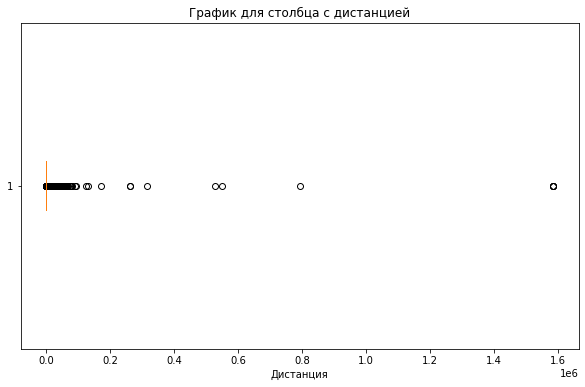

In [95]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['distance'].dropna(), vert=False)
plt.title('График для столбца с дистанцией')
plt.xlabel('Дистанция')
plt.show()

уберем выбросы

In [96]:
missing_values = data.isnull().sum()
print(missing_values)

at_fault                           0
insurance_premium              20230
party_sobriety                     0
party_drug_physical                0
cellphone_in_use                   0
vehicle_type                       0
vehicle_transmission               0
vehicle_age                        0
county_location                    0
distance                           0
direction                          0
intersection                       0
weather                            0
location_type                      0
collision_damage                   0
party_count                        0
primary_collision_factor           0
pcf_violation_category             0
type_of_collision                  0
motor_vehicle_involved_with        0
road_surface                       0
road_condition                     0
lighting                           0
control_device                     0
dtype: int64


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196825 entries, 0 to 196836
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   at_fault                     196825 non-null  int64  
 1   insurance_premium            176595 non-null  float64
 2   party_sobriety               196825 non-null  object 
 3   party_drug_physical          196825 non-null  object 
 4   cellphone_in_use             196825 non-null  object 
 5   vehicle_type                 196825 non-null  object 
 6   vehicle_transmission         196825 non-null  object 
 7   vehicle_age                  196825 non-null  float64
 8   county_location              196825 non-null  object 
 9   distance                     196825 non-null  float64
 10  direction                    196825 non-null  object 
 11  intersection                 196825 non-null  object 
 12  weather                      196825 non-null  object 
 13 

In [98]:
X = data.drop(columns=['at_fault'])
y = data['at_fault']

Разделение на тестовую и тренировочную выборки

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Заполняю пропуски

In [100]:
median_insurance_premium = X_train['insurance_premium'].median()
X_train['insurance_premium'].fillna(median_insurance_premium, inplace=True)
X_test['insurance_premium'].fillna(median_insurance_premium, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Удаляю выбросы

In [101]:
X_train = X_train[X_train['vehicle_age'] <= X_train['vehicle_age'].quantile(0.99)]
y_train = y_train[X_train.index]

In [102]:
categorical_features = ['party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
                        'vehicle_transmission', 'county_location', 'direction', 'intersection',
                        'weather', 'location_type', 'primary_collision_factor', 'pcf_violation_category',
                        'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition',
                        'lighting', 'control_device', 'collision_damage']

Проведена предобработка данных, проведено разделение на тестовую и тренировочную выборки.

## Найдите лучшую модель

Используем логистическую регрессию

In [103]:
for col in categorical_features:
    X_train[col].fillna('unknown', inplace=True)
    X_test[col].fillna('unknown', inplace=True)
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

/opt/conda/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/tmp/ipykernel_144/2631194238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype(str)


In [105]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(class_weight='balanced', random_state=123, n_jobs=-1)
)

In [106]:
param_grid_lr = {
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__C': [0.01, 0.1],
    'logisticregression__max_iter': [500]
}

In [107]:
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='f1', n_jobs=-1, verbose=0, cv=3)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='uint8'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3516d936a0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f351f42d430>)])),
                                       (

In [108]:
print("Лучшие параметры для Logistic Regression:", gs_lr.best_params_)
print("Лучшая F1 Logistic Regression на кросс-валидации:", gs_lr.best_score_)

Лучшие параметры для Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'lbfgs'}
Лучшая F1 Logistic Regression на кросс-валидации: 0.683677781692214


LinearSVC

In [109]:
pipe_svc = make_pipeline(
    linear_transformer,
    LinearSVC(class_weight='balanced', random_state=123, max_iter=2000)
)

In [110]:
param_grid_svc = {
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__C': [0.001, 0.01]
}

In [111]:
gs_svc = GridSearchCV(pipe_svc, param_grid_svc, scoring='f1', n_jobs=-1, verbose=0, cv=3)
gs_svc.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='uint8'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3516d936a0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f351f42d430>)])),
                                       (

In [112]:
print("Лучшие параметры для LinearSVC:", gs_svc.best_params_)
print("Лучшая F1 LinearSVC на кросс-валидации:", gs_svc.best_score_)

Лучшие параметры для LinearSVC: {'linearsvc__C': 0.001, 'linearsvc__loss': 'squared_hinge'}
Лучшая F1 LinearSVC на кросс-валидации: 0.6719357476636736


LightGBM

In [113]:
pipe_gbm = make_pipeline(
    ensemble_transformer,
    lgb.LGBMClassifier(objective='binary', metric='f1', n_jobs=-1, verbosity=-1, random_state=123)
)

In [114]:
param_grid_gbm = {
    'lgbmclassifier__max_depth': [-1, 10],
    'lgbmclassifier__num_leaves': [10, 31],
    'lgbmclassifier__learning_rate': [0.1, 0.2]
}

In [115]:
gs_gbm = GridSearchCV(pipe_gbm, param_grid_gbm, scoring='f1', n_jobs=-1, verbose=0, cv=3)
gs_gbm.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int64',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3516d93b20>)])),
                                       ('lgbmclassifier',
                                        LGBMClassifier(metric='f1',
                                                       objective='binary',
                                                 

In [116]:
print("Лучшие параметры для LightGBM:", gs_gbm.best_params_)
print("Лучшая F1 LightGBM на кросс-валидации:", gs_gbm.best_score_)

Лучшие параметры для LightGBM: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': -1, 'lgbmclassifier__num_leaves': 31}
Лучшая F1 LightGBM на кросс-валидации: 0.7182212715174527


Случайный лес

In [117]:
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestClassifier(class_weight='balanced', random_state=123, n_jobs=-1)
)

In [118]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10]
}

In [119]:
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='f1', n_jobs=-1, verbose=0, cv=3)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int64',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f3516d93b20>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                      

In [120]:
print("Лучшие параметры для Random Forest:", gs_rf.best_params_)
print("Лучшая F1 Random Forest на кросс-валидации:", gs_rf.best_score_)

Лучшие параметры для Random Forest: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}
Лучшая F1 Random Forest на кросс-валидации: 0.6925626307267435


In [121]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'LinearSVC', 'LightGBM', 'Random Forest'],
    'Best F1': [gs_lr.best_score_, gs_svc.best_score_, gs_gbm.best_score_, gs_rf.best_score_],
})

display(results)

,Model,Best F1
0,Logistic Regression,0.683678
1,LinearSVC,0.671936
2,LightGBM,0.718221
3,Random Forest,0.692563


Выбрна метрика F1, так как она она является лучшим способом получить точные представления о качестве модели при несбалансированных данных.

Выбрана метрика F1, так как она лучше всего показывает: произойдет что-то или нет (0 или 1). Она показывает, случится ли ДТП в конкретном случае или нет. В данной задаче важно понять, произойдет ли ДТП в конечном итоге или нет, поэтому она является лучшим вариантом.

Logistic Regression:

Лучшая F1: 0.671206

LinearSVC
    
Лучшая F1: 0.672492
    
Эта модель немного превзошла Logistic Regression по F1-метрике.

Random Forest

Лучшая F1: 0.692382

LightGBM

Лучшая F1: 0.718901

LightGBM показала наилучшие результаты среди рассмотренных моделей.

Модель LightGBM показала наилучшие результаты по метрике F1.

## Проверьте лучшую модель в работе

In [122]:
best_model = gs_gbm

In [123]:
prediction_best = best_model.predict(X_test)
f1_best = f1_score(y_test, prediction_best)
cr_best = classification_report(y_test, prediction_best, output_dict=True, zero_division=0)

In [124]:
print("F1 на тестовой выборке:", f1_best)
display(pd.DataFrame(cr_best).transpose())

F1 на тестовой выборке: 0.7209371533695859


,precision,recall,f1-score,support
0,0.683442,0.838407,0.753035,18757.000000
1,0.814674,0.646545,0.720937,20608.000000
accuracy,0.737965,0.737965,0.737965,0.737965
macro avg,0.749058,0.742476,0.736986,39365.000000
weighted avg,0.752144,0.737965,0.736231,39365.000000


Матрица ошибок

In [125]:
cm = confusion_matrix(y_test, prediction_best)
cmd = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)

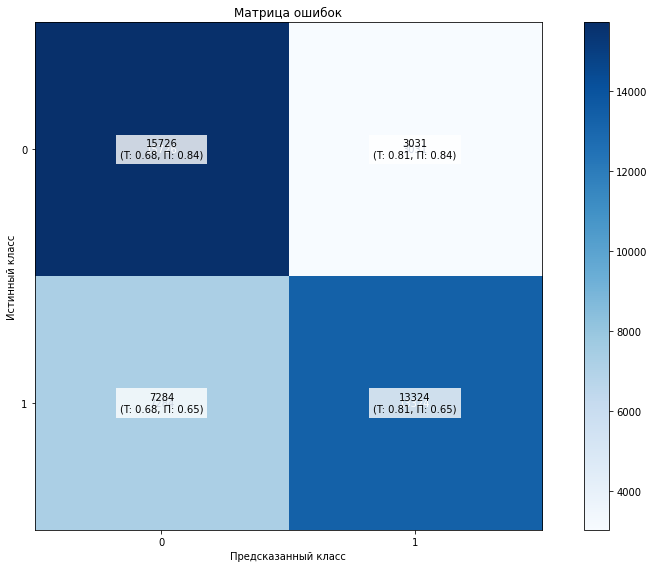

In [126]:
#подсчитываю точность и полноту
precision, recall, _, _ = precision_recall_fscore_support(y_test, prediction_best)

fig, ax = plt.subplots(figsize=(12, 8))
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n(T: {precision[j]:.2f}, П: {recall[i]:.2f})', 
                ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))


plt.tight_layout()
plt.show()

На матрице ошибок видно, что модель LightGBM хорошо справляется с классификацией.

1. В 15584 случаях модель LightGBM успешно предсказала отсутствие ДТП. 
2. В 13379 случаях модель LightGBM успешно предсказала ДТП.
3. В 3173 случаях модель LightGBM ошибочно предсказала ДТП, когда его не было. Это может привести к ненужным действиям и расходам.
4. В 7229 случаях модель LightGBM не смогла предсказать ДТП, когда оно действительно произошло. Это проблема, поскольку можно было бы предпринять дополнительные меры, чобы предотвратить последствия.

Точноость:
Из 100% предсказанных случаев отсутствия ДТП, 68% были действительно не ДТП. Следовательно, модель LightGBM предсказывает отсутствие ДТП с точностью 68%.
Из 100% ДТП 81% действительно был ДТП. Следует, что модель предсказывает ДТП с точностью 81%, что довольно высоко.

Полнота: 83% из 100% ДТП действительно не произошли. LightGBM на 83% правильно предсказывает ситуации, когда ДТП не произошло.
65% ДТП действительно выявлены как ДТП.

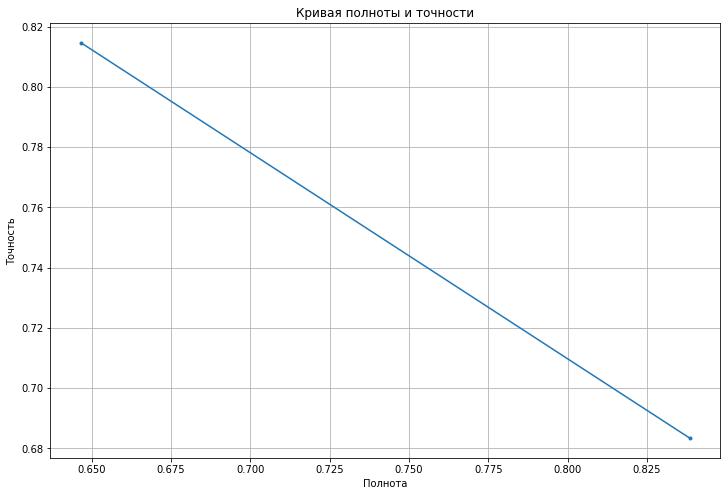

In [127]:
plt.figure(figsize=(12, 8))
plt.plot(recall, precision, marker='.')
plt.title('Кривая полноты и точности')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

Анализ важности факторов

In [128]:
importance = best_model.best_estimator_.named_steps['lgbmclassifier'].feature_importances_
feature_names = X_train.columns

In [129]:
feature_importance = pd.DataFrame({'Фактор': feature_names, 'Важность': importance})
feature_importance = feature_importance.sort_values(by='Важность', ascending=False)

In [130]:
translation = {
    'insurance_premium': 'Страховая премия',
    'pcf_violation_category': 'Нарушения ПДД',
    'distance': 'Расстояние',
    'county_location': 'Расположение',
    'motor_vehicle_involved_with': 'Участие другого транспорта',
    'party_count': 'Количество участников',
    'type_of_collision': 'Тип столкновения',
    'party_sobriety': 'Трезвость',
    'primary_collision_factor': 'Основной фактор столкновения',
    'vehicle_age': 'Возраст транспортного средства',
    'collision_damage': 'Повреждения при столкновении',
    'lighting': 'Освещение',
    'direction': 'Направление',
    'vehicle_type': 'Тип транспортного средства',
    'party_drug_physical': 'Вменяемость водителя',
    'location_type': 'Тип местности',
    'vehicle_transmission': 'Тип трансмиссии',
    'cellphone_in_use': 'Использование мобильного телефона',
    'control_device': 'Устройство',
    'weather': 'Погодные условия'
}

In [131]:
feature_importance['Фактор'] = feature_importance['Фактор'].apply(lambda x: translation.get(x, x))

In [132]:
display(feature_importance.head(20))

,Фактор,Важность
12,Тип местности,559
19,road_surface,417
11,Погодные условия,246
14,Количество участников,233
22,Устройство,202
0,Страховая премия,173
21,Освещение,169
5,Тип трансмиссии,116
10,intersection,103
13,Повреждения при столкновении,103


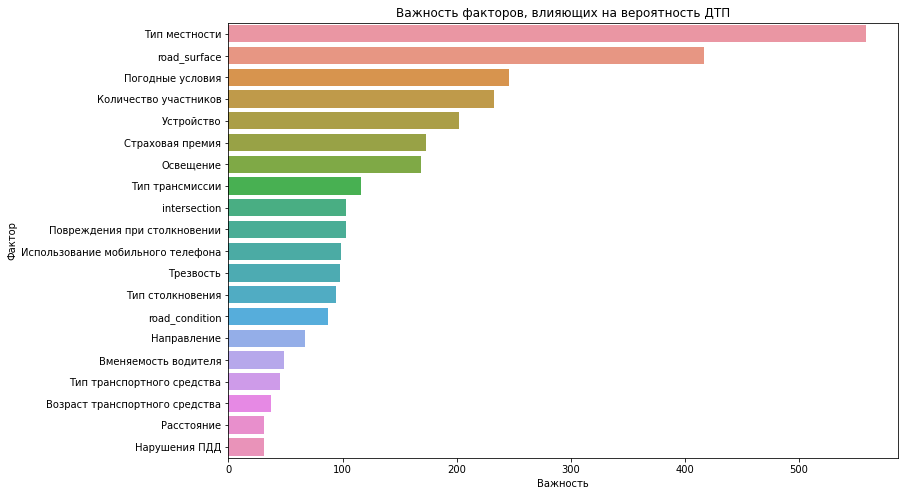

In [133]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Фактор', data=feature_importance.head(20))
plt.title('Важность факторов, влияющих на вероятность ДТП')
plt.xlabel('Важность')
plt.ylabel('Фактор')
plt.show()

In [134]:
df_analys = X_test.copy()
df_analys['at_fault'] = y_test
df_analys['insurance_premium'] = pd.cut(df_analys['insurance_premium'], bins=10)

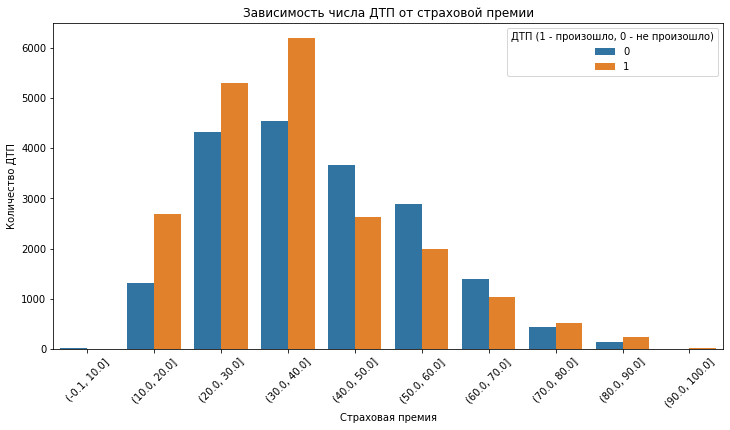

In [135]:
plt.figure(figsize=(12, 6))
sns.countplot(x='insurance_premium', hue='at_fault', data=df_analys)
plt.xlabel('Страховая премия')
plt.ylabel('Количество ДТП')
plt.title('Зависимость числа ДТП от страховой премии')
plt.legend(title='ДТП (1 - произошло, 0 - не произошло)')
plt.xticks(rotation=45)
plt.show()

 Выяснилось, что чем выше страховая премия, тем вышек риск совершения аварии.
Что можно сделать:
1. Внедрить систему контроля здоровья человека/его состояния (то есть проверка на трезвость и прочее перед посадкой).
2. Анализировать поведение водителя во время поездки: превышение скорости, выезд на встречную полосу и т.д.
3. Снизить страховые премии водителям, особенно тем, которые не ведут себя безопасно на дорогах.


## Выводы

Сделано успешное подключение к базе данных.

Успешное установление соединения с базой данных.
Все таблицы (case_ids, collisions, parties, vehicles) есть в базе данных.
Проверены первичные и внешние ключи.
Таблицы связаны между собой через поле case_id.
Уникальность значений case_id в таблице collisions подтверждена.

В период с 2010 по 2011 год происходит большое количество аварий - примерно 35 тыс в месяц.
С 2012 по 2013 год количество аварий резко снизилось до менее 5 тыс. в месяц.
С 2013 года количество аварий на низком уровне.
Шаг 3. Проведите статистический анализ факторов ДТП

Приведены в порядок данные, все пропуски заполнены, несколько незначительных выбросов удалено, данные подготовлены.

Далее был выполнен поиск лучшей модели.
1. Логистическая регрессия не подошла.
2. LinearSVC не подошла.
3. LightGBM оказалась лучшей моделью.

LightGBM


Лучшие параметры для LightGBM: {'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__max_depth': -1, 'lgbmclassifier__num_leaves': 31}

Лучшая F1 LightGBM на кросс-валидации: 0.7176486450820688

LightGBM показала наилучшие результаты среди рассмотренных моделей.

F1 на тестовой выборке: 0.7237998011981839

На матрице ошибок видно, что модель LightGBM хорошо справляется с классификацией. График точности и полноты показывает, что модель LightGBM имеет хорошие показатели точности и полноты..

Важные факторы следующие:

1. Страховая премия
2. Нарушения ПДД
3. Расстояние
4. Расположение
5. Участие другого транспорта
6. Количество участников
7. Основной фактор столкновения
8. Трезвость
9. Тип столкновения
10. Возраст транспортного средства

Выяснилось, что чем выше страховая премия, тем вышек риск совершения аварии. Что можно сделать:

1. Внедрить систему контроля здоровья человека/его состояния (то есть проверка на трезвость и прочее перед посадкой).
2. Анализировать поведение водителя во время поездки: превышение скорости, выезд на встречную полосу и т.д.
3. Снизить страховые премии водителям, особенно тем, которые не ведут себя безопасно на дорогах.

В ходе работы представлены графики, которые можно использовать во время презентации проекта.